# Desarrollo de un modelo de IA para la detección temprana del Parkinson

## Importación de librerías y configuraciones

In [1]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Configuraciones
pd.set_option('display.max_columns', None)      # Permitir que se muestren todas las columnas
pd.set_option('display.max_rows', None)         # Permitir que se muestren todas las filas

sns.set(style="whitegrid")                      # Estilo de las gráficas
palette_set2 = sns.color_palette('Set2')        # Paleta de colores Set2

## Carga de datos y exploración inicial

A continuación se describen las variables presentes en los archivos `metadata_hc.csv` y `metadata_pd.csv`:

| Variable                  | Descripción                                                                 |
|---------------------------|-----------------------------------------------------------------------------|
| `ID`                     | Identificador único del paciente o muestra.                                  |
| `Group`                  | Grupo de origen del paciente: `HC` (sano) o `PD` (con Parkinson).            |
| `Date`                   | Fecha de grabación del audio o evaluación clínica.                           |
| `Sex`                    | Sexo del paciente: `1` (hombre) o `0` (mujer).                               |
| `Age`                    | Edad del paciente en años.                                                   |
| `Diagnosis`              | Información textual sobre el diagnóstico (puede estar vacía o redundante).   |
| `Vocal tremor`           | Presencia de temblor vocal. Valor binario (`1` / `0`).                       |
| `Cephalic tremor`        | Presencia de temblor cefálico (cabeza). Valor binario (`1` / `0`).           |
| `Mandibular tremor`      | Presencia de temblor mandibular (mandíbula). Valor binario (`1` / `0`).      |
| `Sialorrhoea`            | Presencia de babeo excesivo. Valor binario (`1` / `0`).                      |
| `Dysphagia`              | Presencia de dificultad al tragar. Valor binario (`1` / `0`).                |
| `Hypophonic voice`       | Voz hipofónica (débil o de baja intensidad).                                 |
| `Time Disease (years)`   | Tiempo desde el diagnóstico de la enfermedad de Parkinson (en años).         |
| `UPDRS scale`            | Puntuación en la escala UPDRS (Unified Parkinson's Disease Rating Scale).    |
| `H-Y Stadium`            | Estadio en la escala de Hoehn y Yahr (gravedad del Parkinson).               |
| `Date Evaluation Scales` | Fecha de evaluación clínica o cuestionarios.                                 |
| `Medication`             | Medicación que toma el paciente.                       |
| `Medication status`      | Estado del paciente respecto a la medicación (`ON` / `OFF`, etc.).           |
| `Occupation`             | Profesión del paciente.                                                      |
| `Fiber/VocalFolds`       | Observación sobre las cuerdas vocales. (`Normal` / `Not performed` / `Texto libre`)      |
| `Observations`           | Notas clínicas adicionales.                                                  |
| `Doctor`                 | Nombre del médico o evaluador.                                               |
| `Audio`                  | Nombre del archivo de audio asociado.                                        |

In [3]:
# Cargar metadatos de los archivos CSV
df_hc = pd.read_csv(r"metadata\metadata_hc.csv")
df_pd = pd.read_csv(r"metadata\metadata_pd.csv")

# Unir en un único DataFrame
df_metadata = pd.concat([df_hc, df_pd], ignore_index=True)

# Mostrar primeras filas
df_metadata.head()

,ID,Group,Date,Sex,Age,Diagnosis,Vocal tremor,Cephalic tremor,Mandibular tremor,Sialorrhoea,Dysphagia,Hypophonic voice,Time Disease (years),UPDRS scale,H-Y Stadium,Date Evaluation Scales,Medication,Medication status,Occupation,Fiber/VocalFolds,Observations,Doctor,Audio,Vocal folds analysis
0,34,HC,2016-05-01,1.0,77.0,normal,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,retired,Not performed,NaN,NaN,data/audios/HC_ABLANDADA_0034.wav,NaN
1,34,HC,2016-05-01,1.0,77.0,normal,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,retired,Not performed,NaN,NaN,data/audios/HC_PIDIO_0034.wav,NaN
2,34,HC,2016-05-01,1.0,77.0,normal,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,retired,Not performed,NaN,NaN,data/audios/HC_BURRO_0034.wav,NaN
3,34,HC,2016-05-01,1.0,77.0,normal,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,retired,Not performed,NaN,NaN,data/audios/HC_E2_0034.wav,NaN
4,34,HC,2016-05-01,1.0,77.0,normal,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,retired,Not performed,NaN,NaN,data/audios/HC_GANGA_0034.wav,NaN


## Limpieza básica de datos

In [4]:
# Limpiar nombres de columnas (quitar espacios en blanco al inicio y final)
df_metadata.columns = df_metadata.columns.str.strip()

In [5]:
# Dimensiones del datafdrame
print(f"Filas: {df_metadata.shape[0]}, Columnas: {df_metadata.shape[1]}")

Filas: 2903, Columnas: 24


In [6]:
# Tipos de datos y valores nulos
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2903 entries, 0 to 2902
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      2903 non-null   int64  
 1   Group                   2903 non-null   object 
 2   Date                    2874 non-null   object 
 3   Sex                     2875 non-null   float64
 4   Age                     2847 non-null   float64
 5   Diagnosis               2903 non-null   object 
 6   Vocal tremor            2903 non-null   int64  
 7   Cephalic tremor         2903 non-null   int64  
 8   Mandibular tremor       2903 non-null   int64  
 9   Sialorrhoea             2903 non-null   int64  
 10  Dysphagia               2903 non-null   int64  
 11  Hypophonic voice        2903 non-null   int64  
 12  Time Disease (years)    1315 non-null   float64
 13  UPDRS scale             1289 non-null   float64
 14  H-Y Stadium             1431 non-null   

In [7]:
# Estadísticas básicas de columnas numéricas
df_metadata.describe()

,ID,Sex,Age,Vocal tremor,Cephalic tremor,Mandibular tremor,Sialorrhoea,Dysphagia,Hypophonic voice,Time Disease (years),UPDRS scale,H-Y Stadium,Doctor
count,2903.000000,2875.000000,2847.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,1315.000000,1289.000000,1431.000000,1150.000000
mean,67.122632,0.565217,67.793818,-0.021357,-0.001033,-0.010679,0.095419,0.009645,0.122632,6.979468,17.611327,2.232355,1.549565
std,43.507021,0.495815,11.100796,0.336539,0.366121,0.352538,0.470556,0.380309,0.492656,5.380955,11.674755,0.697644,1.805772
min,4.000000,0.000000,31.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,2.000000,1.000000,0.000000
25%,30.000000,0.000000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,10.000000,2.000000,0.000000
50%,60.000000,1.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,15.000000,2.000000,0.000000
75%,112.000000,1.000000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,22.000000,3.000000,4.000000
max,145.000000,1.000000,88.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000,59.000000,5.000000,4.000000


In [8]:
# Eliminación de duplicados
num_duplicados = df_metadata.duplicated().sum()
print(f"Filas duplicadas: {num_duplicados}")

Filas duplicadas: 0


## Análisis exploratorio de datos (EDA)

In [9]:
# Revisar la distribución de las variables categóricas para detectar inconsistencias
for col in ['Group', 'Diagnosis', 'Medication', 'Medication status', 'Sex']:
    print(f"Distribución en '{col}':")
    
    # Contar valores, incluyendo NaN
    value_counts = df_metadata[col].value_counts(dropna=False)
    
    # Calcular longitud máxima del valor representado
    max_len = max(len(repr(val)) for val in value_counts.index)
    
    # Imprimir alineado
    for val, count in value_counts.items():
        print(f"{repr(val):<{max_len}} -> {count:>5}")
    
    print("")

Distribución en 'Group':
'PD' ->  1459
'HC' ->  1444

Distribución en 'Diagnosis':
'normal'                                                                ->  1363
'enfermedad-parkinson'                                                  ->  1089
'sindrome-parkinsoniano'                                                ->    86
'unknown'                                                               ->    56
'enfermedad-parkinson-y-temblor-esencial'                               ->    30
'enfermedad-parkinson-mutacion-parkina'                                 ->    30
'enfermedad-parkinson-juvenil'                                          ->    29
'enfermedad-parkinson-y-templor-esencial'                               ->    29
'enfermedad-parkinson-predominio-izquierdo'                             ->    29
'enfermedad-parkinson-mutacion-lrrk2'                                   ->    28
'sindrome-parkinson-vascular'                                           ->    28
'posible-enfermedad-parkin

In [10]:
# Limpiar espacios en la columna 'Medication status' ('ON ' - > 'ON')
df_metadata['Medication status'] = df_metadata['Medication status'].apply(
    lambda x: x.strip() if isinstance(x, str) else x
)

In [11]:
# Convertir 'Medication status' ON/OFF a binario 1/0
df_metadata['Medication status'] = df_metadata['Medication status'].map({'ON': 1, 'OFF': 0}).fillna(0).astype(int)

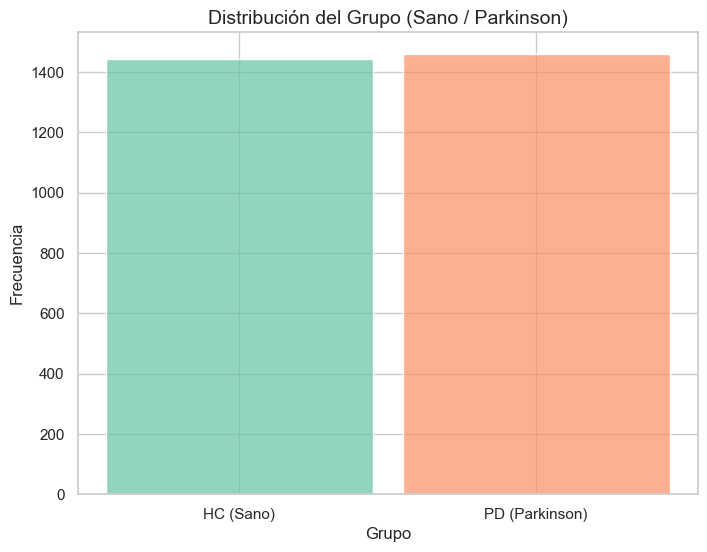

In [ ]:
# Distribución del Grupo (Sano / Parkinson)
plt.figure(figsize=(8,6))
sns.histplot(
    data=df_metadata, x='Group', hue='Group', palette=[palette_set2[0], palette_set2[1]], shrink=0.9, binwidth=0.4, discrete=True, alpha=0.7
)
plt.title('Distribución del Grupo (Sano / Parkinson)', fontsize=14)
plt.xlabel('Grupo', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend([],[], frameon=False)
plt.xticks(ticks=[0, 1], labels=['HC (Sano)', 'PD (Parkinson)'])
plt.show()

# Mostrar los números exactos
print(df_metadata['Group'].value_counts())

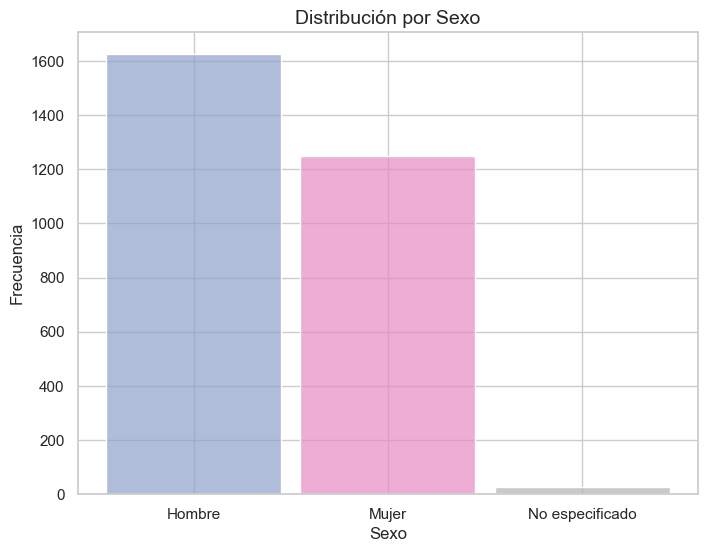

In [25]:
# Distribución por Sexo
plt.figure(figsize=(8,6))
sns.histplot(
    data=df_metadata.assign(
        Sex=df_metadata['Sex'].map({0: 'Mujer', 1: 'Hombre'}).fillna('No especificado')
    ),
    x='Sex', hue='Sex',
    palette=[palette_set2[2], palette_set2[3], palette_set2[7]],
    shrink=0.9, binwidth=0.4, discrete=True, alpha=0.7
)
plt.title('Distribución por Sexo', fontsize=14)
plt.xlabel('Sexo', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend([],[], frameon=False)
plt.show()

In [22]:
# Cuenta los valores
conteo_sexo = df_metadata['Sex'].value_counts(dropna=False)

# Mostramos los resultados
num_hombres = conteo_sexo.get(1, 0)
num_mujeres = conteo_sexo.get(0, 0)
num_no_especificado = conteo_sexo.get(np.nan, 0)

print(f"Hombres (1): {num_hombres}")
print(f"Mujeres (0): {num_mujeres}")
print(f"No especificado (NaN): {num_no_especificado}")


Hombres (1): 1625
Mujeres (0): 1250
No especificado (NaN): 28


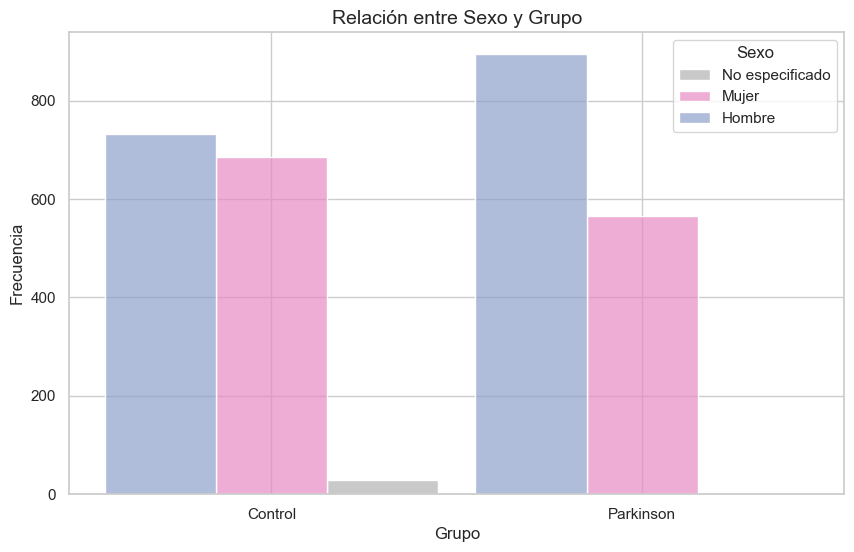

In [27]:
# Relación entre Sexo y Grupo
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_metadata.assign(
        Sex=df_metadata['Sex'].map({0: 'Mujer', 1: 'Hombre'}).fillna('No especificado')
    ),
    x='Group', hue='Sex', multiple='dodge',
    palette=[palette_set2[2], palette_set2[3], palette_set2[7]],
    shrink=0.9, binwidth=0.4, discrete=True, alpha=0.7
)
plt.title('Relación entre Sexo y Grupo', fontsize=14)
plt.xlabel('Grupo', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Control', 'Parkinson'])
plt.legend(title='Sexo', labels=['No especificado', 'Mujer', 'Hombre'])
plt.show()

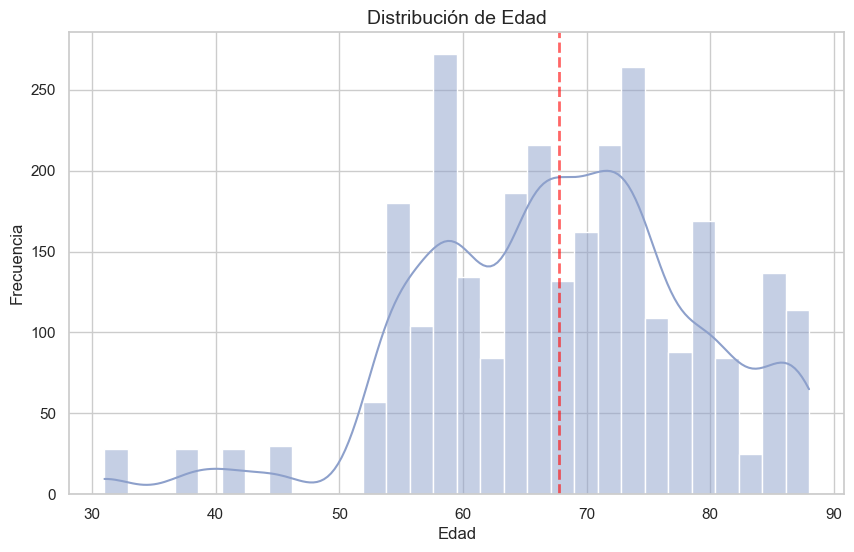

In [50]:
# Distribución de Edad
plt.figure(figsize=(10,6))
sns.histplot(df_metadata['Age'].dropna(), bins=30, kde=True, color=palette_set2[2])
media_edad = df_metadata['Age'].mean()
plt.axvline(media_edad, color='red', linestyle='--', linewidth=2, alpha=0.6, label=f'Media = {media_edad:.2f}')
plt.title('Distribución de Edad', fontsize=14)
plt.xlabel('Edad', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.show()

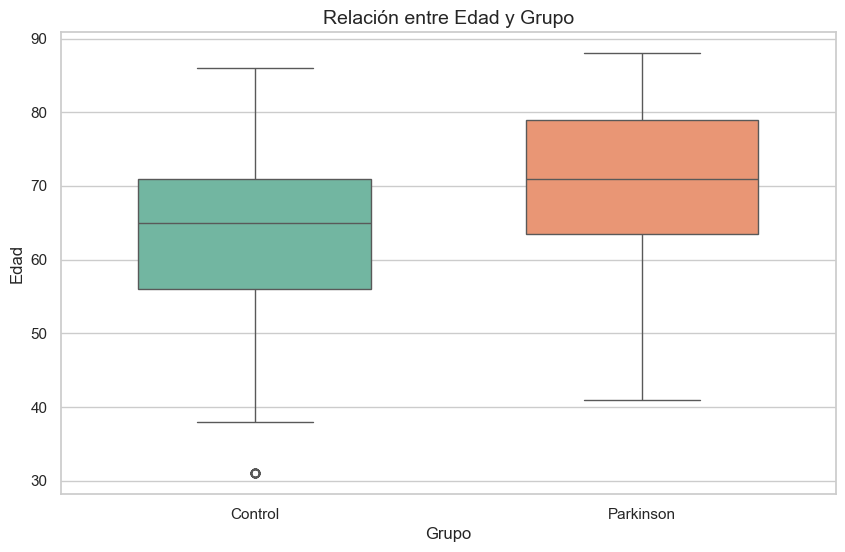

In [51]:
# Relación entre Edad y Grupo
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_metadata, x='Group', y='Age', hue='Group', palette=[palette_set2[0], palette_set2[1]], width=0.6, legend=False
)
plt.title('Relación entre Edad y Grupo', fontsize=14)
plt.xlabel('Grupo', fontsize=12)
plt.ylabel('Edad', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Control', 'Parkinson'])
plt.show()

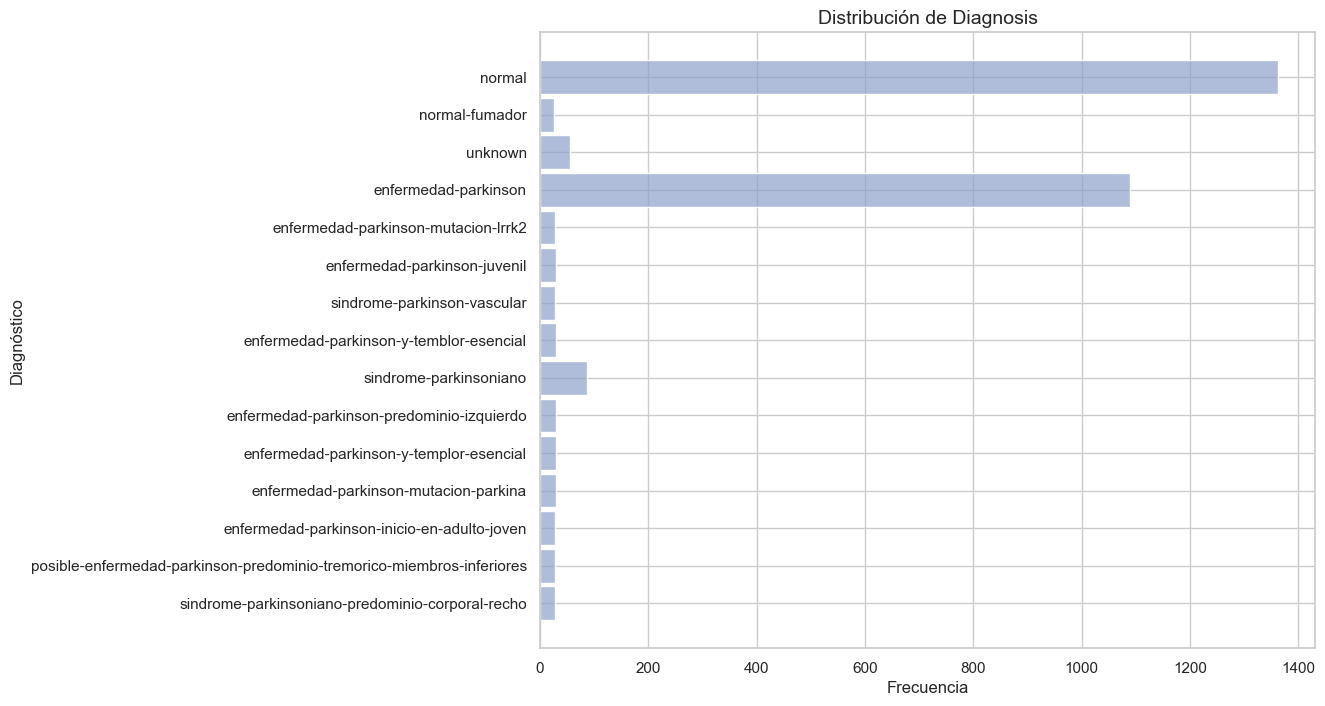

In [52]:
# Distribución de Diagnosis
plt.figure(figsize=(10,8))
sns.histplot( data=df_metadata, y='Diagnosis', color=palette_set2[2], shrink=0.9, alpha=0.7, discrete=True, multiple='layer'
)
plt.title('Distribución de Diagnosis', fontsize=14)
plt.xlabel('Frecuencia', fontsize=12)
plt.ylabel('Diagnóstico', fontsize=12)
plt.show()

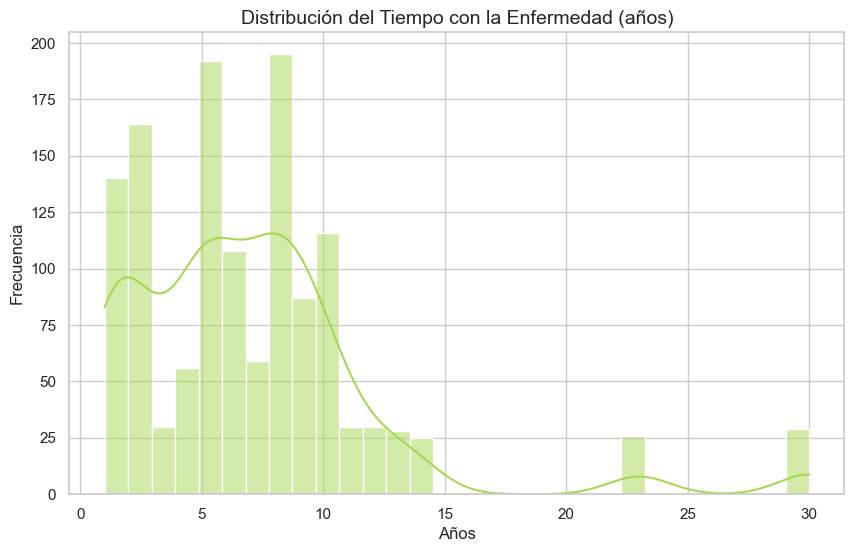

In [53]:
# Distribución de Time Disease
plt.figure(figsize=(10,6))
sns.histplot(df_metadata['Time Disease (years)'].dropna(), bins=30, kde=True, color=palette_set2[4])
plt.title('Distribución del Tiempo con la Enfermedad (años)', fontsize=14)
plt.xlabel('Años', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.show()